In [195]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import  precision_recall_curve, average_precision_score,f1_score, recall_score, precision_score,fbeta_score,make_scorer
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.feature_selection import RFE

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler
from collections import Counter
from scipy.stats import uniform


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
import xgboost
from sklearn.ensemble import RandomForestClassifier, IsolationForest, StackingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ClassPredictionError


In [196]:
df=pd.read_csv(r"D:\Google Drive\McGill\Winter Semester\W2\Enterprise 2\Group Project\Revenue-Radar\train_df.csv")
pd.set_option('display.max_columns', None)
df.head(1)


,fullVisitorId,FirstChannelVisit,LastChannelVisit,at_least_one_conversion,country,continent,subContinent,TotalVisits,TotalBounces,Organic Search,Social,Direct,Paid Search,Referral,Affiliates,Display,(Other),TotalPageviews,desktop,mobile,tablet,FirstSessionPageviews,LastSessionPageviews,CampaignVisits,isTrueDirect,AdContentVisits,Source_PC1,Source_PC2,Source_PC3
0,4823595352351,Organic Search,Organic Search,0,China,Asia,Eastern Asia,1,1,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,-0.406531,-0.073766,0.171027


In [197]:
df.columns

Index(['fullVisitorId', 'FirstChannelVisit', 'LastChannelVisit',
       'at_least_one_conversion', 'country', 'continent', 'subContinent',
       'TotalVisits', 'TotalBounces', 'Organic Search', 'Social', 'Direct',
       'Paid Search', 'Referral', 'Affiliates', 'Display', '(Other)',
       'TotalPageviews', 'desktop', 'mobile', 'tablet',
       'FirstSessionPageviews', 'LastSessionPageviews', 'CampaignVisits',
       'isTrueDirect', 'AdContentVisits', 'Source_PC1', 'Source_PC2',
       'Source_PC3'],
      dtype='object')

0    0.986978
1    0.013022
Name: at_least_one_conversion, dtype: float64


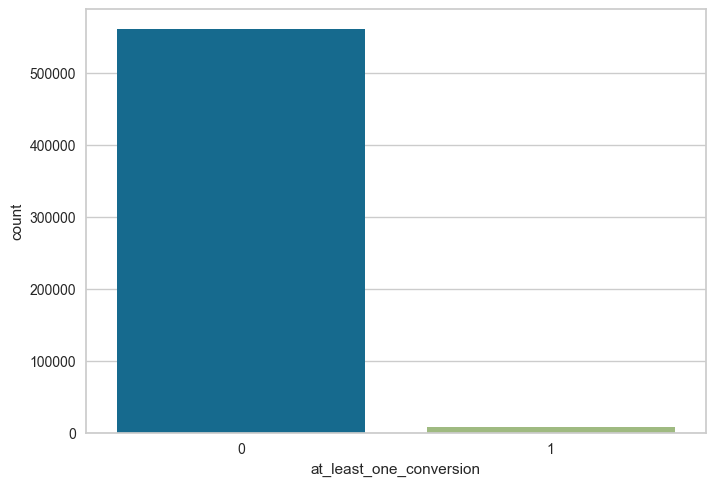

In [198]:
# Checking the class distribution of the target variable
print(df['at_least_one_conversion'].value_counts(normalize=True))
sns.countplot(x=df['at_least_one_conversion']);

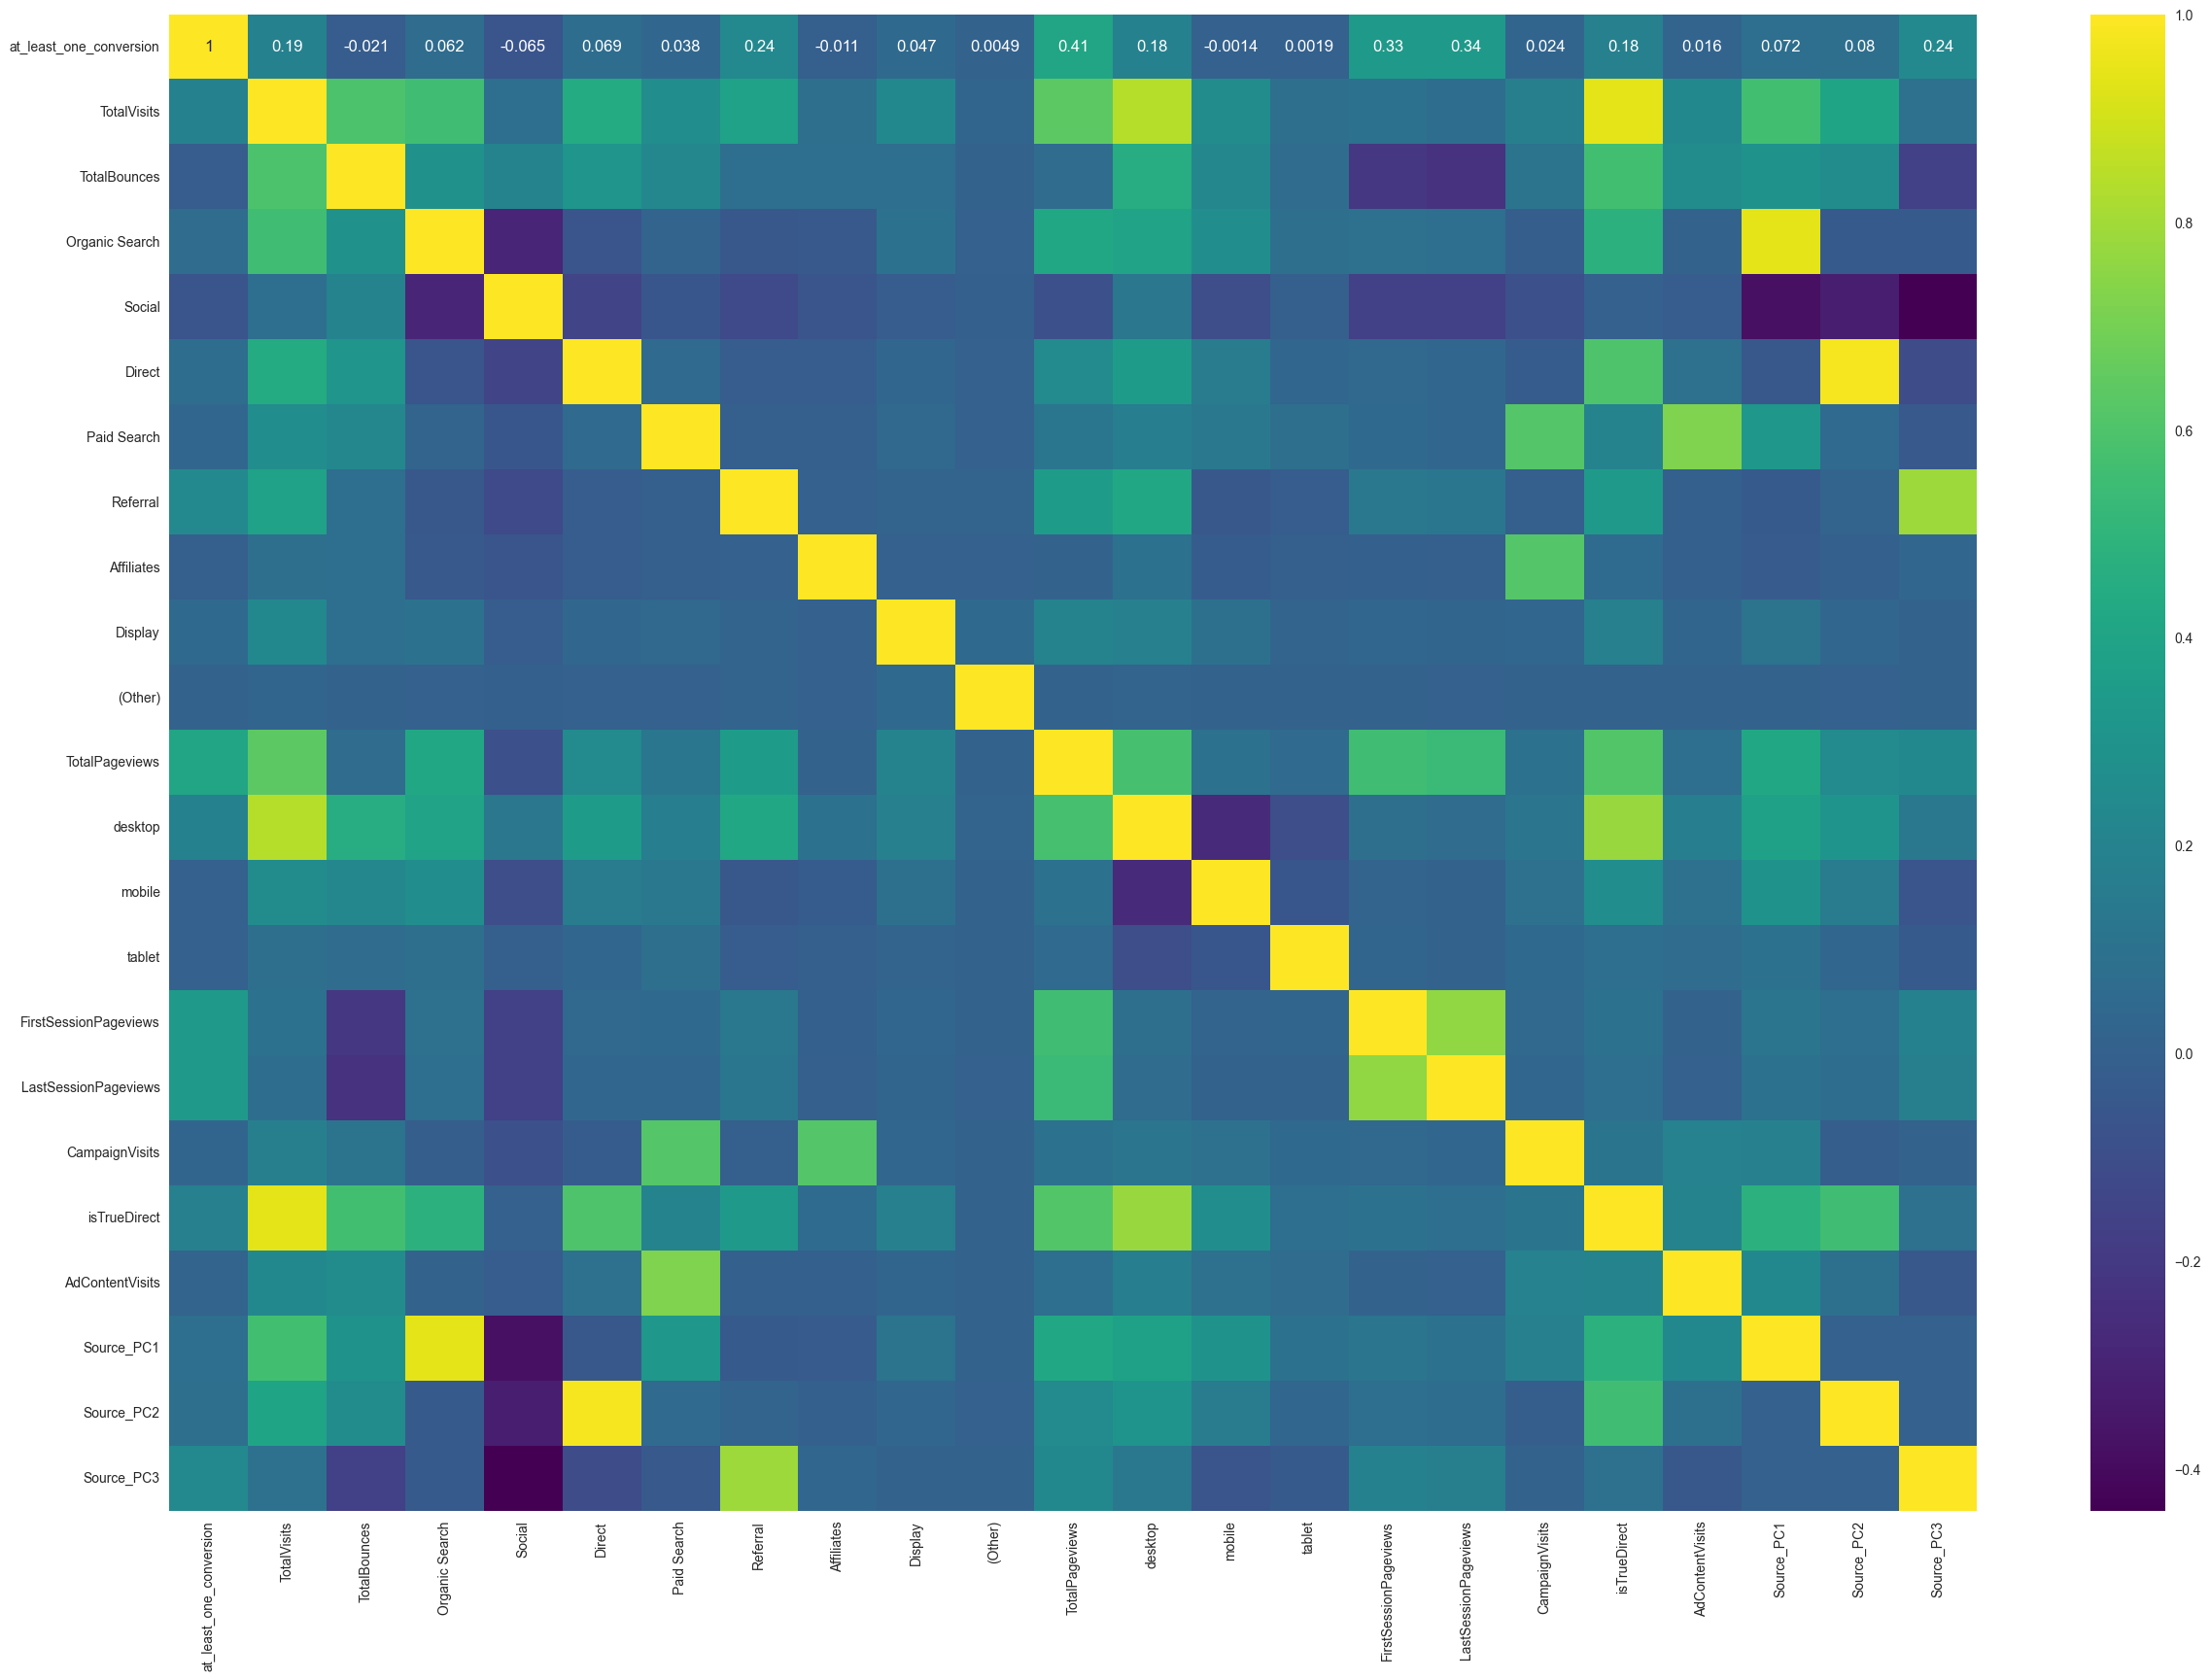

In [199]:
numeric_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(30,20))
sns.heatmap(numeric_df.corr(),annot=True,cmap='viridis');

In [200]:
#numeric_df.corr()

# correlation gretaer than 0.5
correlation = numeric_df.corr()
correlation = correlation.abs().unstack()
correlation = correlation.sort_values(ascending=False)
correlation = correlation[correlation > 0.5]
correlation = correlation[correlation < 1]
correlation = pd.DataFrame(correlation).reset_index()
correlation.columns = ['feature1', 'feature2', 'correlation']




In [201]:
df.shape

(567490, 29)

In [202]:
def preprocess_data(df, country_categories, pca_model=None, kmeans_model=None, fit_pca=True, fit_kmeans=True):
    # Validate presence of 'fullVisitorId'
    if 'fullVisitorId' not in df.columns:
        raise KeyError("DataFrame must include 'fullVisitorId' column.")

    # Calculate User Engagement Depth
    df['UserEngagementDepth'] = df['TotalPageviews'] / df['TotalVisits']
    df['UserEngagementDepth'].replace([float('inf'), -float('inf'), float('nan')], 0, inplace=True)
    
    # Standardize select features for clustering to improve performance
    features_for_clustering = ['TotalPageviews', 'TotalVisits', 'UserEngagementDepth', 'desktop', 'mobile', 'tablet']
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[features_for_clustering])
    
    # Perform clustering
    if fit_kmeans:
        kmeans_model = KMeans(n_clusters=6, random_state=42)
        clusters = kmeans_model.fit_predict(scaled_features)
    else:
        clusters = kmeans_model.predict(scaled_features)
    df['ClusterLabel'] = clusters
    # One-hot encode the cluster labels if necessary
    cluster_dummies = pd.get_dummies(df['ClusterLabel'], prefix='Cluster', dtype='int64',drop_first=True)
    df = pd.concat([df, cluster_dummies], axis=1)
    df.drop('ClusterLabel', axis=1, inplace=True)

    
    # One-hot encode 'country' and reindex with all possible categories to ensure consistency
    country_encoded = pd.get_dummies(df['country'], prefix='country')
    country_encoded = country_encoded.reindex(columns=['country_' + c for c in country_categories], fill_value=0)
    
    if fit_pca:
        pca_model = PCA(n_components=3)
        country_pca = pca_model.fit_transform(country_encoded)
    else:
        country_pca = pca_model.transform(country_encoded)
    
    country_pca_df = pd.DataFrame(country_pca, columns=['country_PC1', 'country_PC2', 'country_PC3'])
    
    # Merge PCA data back, ensure 'fullVisitorId' is available for any needed operations
    country_pca_df['fullVisitorId'] = df['fullVisitorId'].values
    df = pd.merge(df, country_pca_df, on='fullVisitorId', how='inner')

    df.drop(['fullVisitorId', 'country', 'TotalVisits', 'LastSessionPageviews', 'TotalPageviews'], axis=1, inplace=True)
    
    # Handle other categorical columns
    cat_cols = df.select_dtypes(include='object').columns
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype='int64')
    
    X = df.drop('at_least_one_conversion', axis=1)
    y = df['at_least_one_conversion']
    
    return X, y, pca_model, kmeans_model

### Splitting the dataset into train, test, and validation sets
- Chose stratified sampling to maintain class distribution

In [203]:
# Split the data into training and validation sets directly
df_train, df_val = train_test_split(df, test_size=0.15, random_state=42, stratify=df['at_least_one_conversion'])


In [204]:
country_categories = df['country'].unique().tolist()

In [205]:
# Preprocess the training data; assuming preprocess_data is modified to fit models
X_train, y_train, pca_train, kmeans_train = preprocess_data(df_train, country_categories, fit_pca=True, fit_kmeans=True)


In [206]:
# Preprocess the validation data using the existing PCA and KMeans models
X_val, y_val, _, _ = preprocess_data(df_val, country_categories, pca_model=pca_train, kmeans_model=kmeans_train, fit_pca=False, fit_kmeans=False)


In [207]:
test_df=pd.read_csv(r"D:\Google Drive\McGill\Winter Semester\W2\Enterprise 2\Group Project\Revenue-Radar\test_df.csv")

X_test, y_test, _, _ = preprocess_data(test_df, country_categories, pca_model=pca_train, kmeans_model=kmeans_train, fit_pca=False, fit_kmeans=False)

In [208]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [209]:
def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

In [210]:
from matplotlib.colors import ListedColormap
def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        predictions_train = clf.predict(X_train)
        print("Train Result:\n")
        print(f"accuracy score: {accuracy_score(y_train, predictions_train):.4f}\n")
        print(f"Classification Report: \n {classification_report(y_train, predictions_train)}\n")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, predictions_train)}\n")

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print(f"Average Accuracy: \t {np.mean(res):.4f}")
        print(f"Accuracy SD: \t\t {np.std(res):.4f}")

    else:
        predictions_val = clf.predict(X_val)
        probas_val = clf.predict_proba(X_val)[:, 1]  
        precision, recall, _ = precision_recall_curve(y_val, probas_val)
        average_precision = average_precision_score(y_val, probas_val)
        plot_pr_curve(precision, recall, average_precision)

        fpr, tpr, _ = roc_curve(y_val, probas_val)
        roc_auc = roc_auc_score(y_val, probas_val)
        print(f"roc auc score: {roc_auc}\n")
        plot_roc_curve(fpr, tpr, roc_auc)

        print(f"Classification Report: \n {classification_report(y_val, predictions_val)}\n")
        print(f"Confusion Matrix: \n {confusion_matrix(y_val, predictions_val)}\n")
        ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val).im_.set_cmap(ListedColormap(['#34a853', '#4285f4', '#fbbb07']))
        plt.show()
        print("End of validation Result\n")


In [211]:
X_train.head(1)

,TotalBounces,Organic Search,Social,Direct,Paid Search,Referral,Affiliates,Display,(Other),desktop,mobile,tablet,FirstSessionPageviews,CampaignVisits,isTrueDirect,AdContentVisits,Source_PC1,Source_PC2,Source_PC3,UserEngagementDepth,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,country_PC1,country_PC2,country_PC3,FirstChannelVisit_Affiliates,FirstChannelVisit_Direct,FirstChannelVisit_Display,FirstChannelVisit_Organic Search,FirstChannelVisit_Paid Search,FirstChannelVisit_Referral,FirstChannelVisit_Social,LastChannelVisit_Affiliates,LastChannelVisit_Direct,LastChannelVisit_Display,LastChannelVisit_Organic Search,LastChannelVisit_Paid Search,LastChannelVisit_Referral,LastChannelVisit_Social,continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania,subContinent_Australasia,subContinent_Caribbean,subContinent_Central America,subContinent_Central Asia,subContinent_Eastern Africa,subContinent_Eastern Asia,subContinent_Eastern Europe,subContinent_Melanesia,subContinent_Micronesian Region,subContinent_Middle Africa,subContinent_Northern Africa,subContinent_Northern America,subContinent_Northern Europe,subContinent_Polynesia,subContinent_South America,subContinent_Southeast Asia,subContinent_Southern Africa,subContinent_Southern Asia,subContinent_Southern Europe,subContinent_Western Africa,subContinent_Western Asia,subContinent_Western Europe
0,3,1,0,0,0,4,0,0,0,5,0,0,1,0,3,0,0.571782,-0.093988,0.093681,5.0,0,0,0,0,0,-0.414732,0.909211,0.014556,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### Feature Selection Using Random Forest

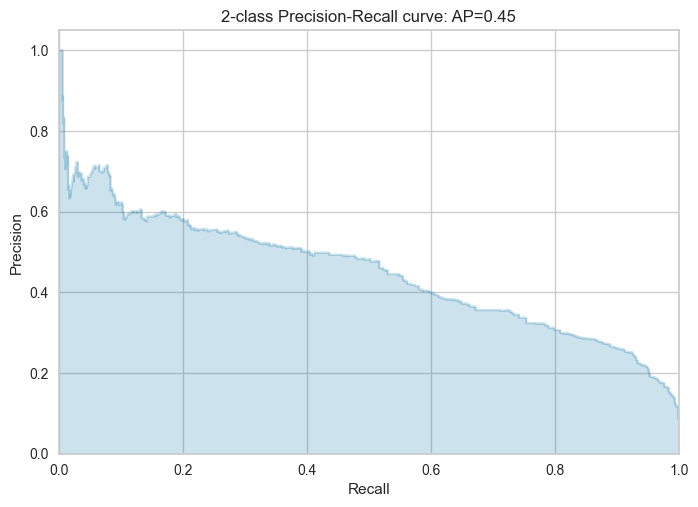

roc auc score: 0.9860414111295221



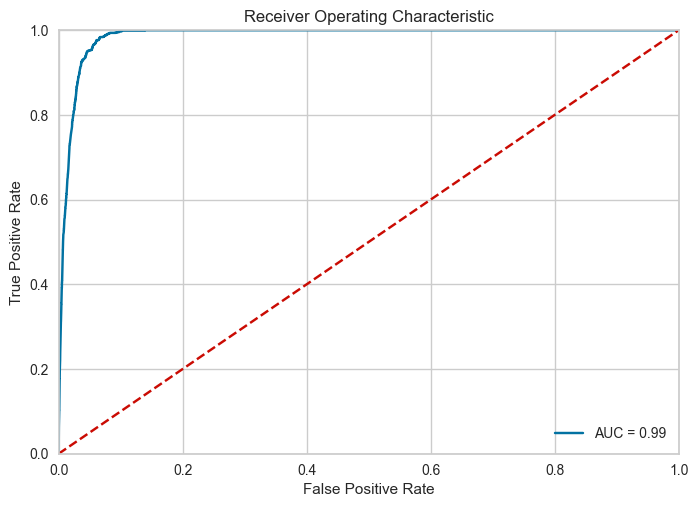

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     84092
           1       0.15      0.98      0.27      1114

    accuracy                           0.93     85206
   macro avg       0.58      0.96      0.61     85206
weighted avg       0.99      0.93      0.95     85206


Confusion Matrix: 
 [[78094  5998]
 [   18  1096]]



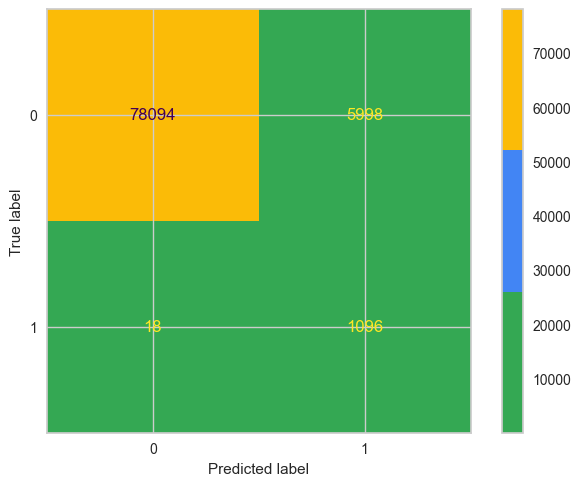

End of validation Result



In [213]:
rf_model=RandomForestClassifier(n_estimators=100,max_depth=5, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
clf_score(rf_model, X_train, y_train, X_val, y_val, train=False)

In [214]:
# getting the feature importance from the random forest model   
feature_importances = pd.DataFrame(rf_model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)


Text(0.5, 1.0, 'Feature Importance')

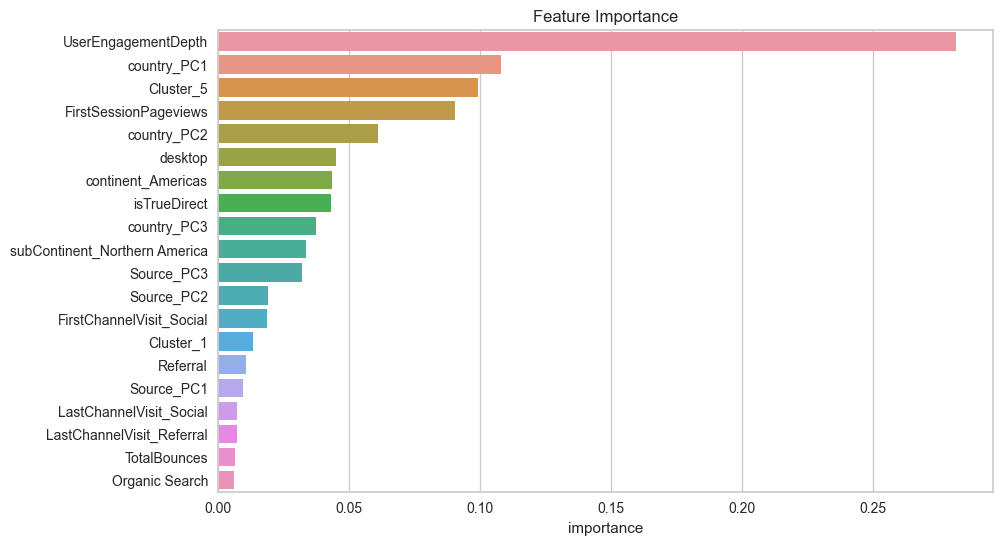

In [215]:
#plotting the top 20 features
plt.figure(figsize=(10, 6)) 
sns.barplot(x=feature_importances['importance'][:20], y=feature_importances.index[:20]);
plt.title('Feature Importance')


In [216]:
# Using the top 20 features from the random forest model
top_features = feature_importances.index[:20]
X_train = X_train[top_features]
X_val = X_val[top_features]
X_test = X_test[top_features]


# Optuna To train and find best hyperparameters for the model

In [217]:
# 1. Apply undersampling to the training set
rus = RandomUnderSampler(random_state=42)  # Set random_state for reproducibility
X_train, y_train = rus.fit_resample(X_train, y_train)

# 2. Apply undersampling to the validation set
#X_val, y_val = rus.fit_resample(X_val, y_val)

# 3. Apply undersampling to the test set
#X_test, y_test = rus.fit_resample(X_test, y_test)

In [218]:
X_train.head(1)

,UserEngagementDepth,country_PC1,Cluster_5,FirstSessionPageviews,country_PC2,desktop,continent_Americas,isTrueDirect,country_PC3,subContinent_Northern America,Source_PC3,Source_PC2,FirstChannelVisit_Social,Cluster_1,Referral,Source_PC1,LastChannelVisit_Social,LastChannelVisit_Referral,TotalBounces,Organic Search
390514,1.0,-0.414732,0,1,0.909211,1,0,0,0.014556,0,-0.307347,-0.332771,1,0,0,-0.625157,1,0,1,0


In [219]:
y_train.value_counts(), y_val.value_counts(), y_test.value_counts()

(0    6491
 1    6491
 Name: at_least_one_conversion, dtype: int64,
 0    84092
 1     1114
 Name: at_least_one_conversion, dtype: int64,
 0    158911
 1      2871
 Name: at_least_one_conversion, dtype: int64)

Logistic Regression focusing only on f1 Score

In [220]:
import mlflow
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
import optuna
import json
import os

# Set the experiment name correctly
mlflow.set_experiment('classification')

def objective(trial):
    C = trial.suggest_loguniform('C', 1e-6, 1e+6)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])
    max_iter = trial.suggest_int('max_iter', 100, 1500)
    threshold = trial.suggest_uniform('threshold', 0.1, 0.9)
    class_weight_method = trial.suggest_categorical('class_weight_method', ['balanced', 'manual'])

    if class_weight_method == 'manual':
        class_weight = {0: 1, 1: 478973 / 6491}
    else:
        class_weight = 'balanced'

    model = LogisticRegression(C=C, solver=solver, max_iter=max_iter, class_weight=class_weight, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1')
    f1_cv = np.mean(cv_scores)
    return f1_cv

def log_dataset_info(X_train, y_train, X_val, y_val, X_test, y_test):
    y_train_counts = y_train.value_counts().to_dict()
    y_val_counts = y_val.value_counts().to_dict()
    y_test_counts = y_test.value_counts().to_dict()

    data_info = {
        'train': {'num_samples': X_train.shape[0], 'num_features': X_train.shape[1], 'feature_names': list(X_train.columns), 'class_distribution': y_train_counts},
        'validation': {'num_samples': X_val.shape[0], 'num_features': X_val.shape[1], 'class_distribution': y_val_counts},
        'test': {'num_samples': X_test.shape[0], 'num_features': X_test.shape[1], 'class_distribution': y_test_counts}
    }

    os.makedirs('/tmp/', exist_ok=True)
    with open('/tmp/dataset_info.json', 'w') as f:
        json.dump(data_info, f, indent=4)
    mlflow.log_artifact('/tmp/dataset_info.json', 'dataset_info')

def log_best_model(trial, model):
    with mlflow.start_run(run_name="Logistic Regression Model Recall"):
        log_dataset_info(X_train, y_train, X_val, y_val, X_test, y_test)

        train_predictions = (model.predict_proba(X_train)[:, 1] >= trial.params['threshold']).astype(int)
        val_predictions = (model.predict_proba(X_val)[:, 1] >= trial.params['threshold']).astype(int)
        test_predictions = (model.predict_proba(X_test)[:, 1] >= trial.params['threshold']).astype(int)

        mlflow.log_params(trial.params)
        mlflow.log_metrics({
            'train_accuracy': accuracy_score(y_train, train_predictions),
            'train_f1_score': f1_score(y_train, train_predictions),
            'train_precision': precision_score(y_train, train_predictions),
            'train_recall': recall_score(y_train, train_predictions),
            'train_roc_auc': roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
            'val_accuracy': accuracy_score(y_val, val_predictions),
            'val_f1_score': f1_score(y_val, val_predictions),
            'val_precision': precision_score(y_val, val_predictions),
            'val_recall': recall_score(y_val, val_predictions),
            'val_roc_auc': roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]),
            'test_accuracy': accuracy_score(y_test, test_predictions),
            'test_f1_score': f1_score(y_test, test_predictions),
            'test_precision': precision_score(y_test, test_predictions),
            'test_recall': recall_score(y_test, test_predictions),
            'test_roc_auc': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        })

        mlflow.sklearn.log_model(model, "best_model_logistic_f1")

# Create and optimize an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_trial = study.best_trial
best_model = LogisticRegression(
    C=best_trial.params['C'], solver=best_trial.params['solver'], max_iter=best_trial.params['max_iter'],
    class_weight={0: 1, 1: 478973 / 6491} if best_trial.params['class_weight_method'] == 'manual' else 'balanced', random_state=42
)
best_model.fit(X_train, y_train)
log_best_model(best_trial, best_model)


[I 2024-04-24 16:35:53,216] A new study created in memory with name: no-name-51b2c2b0-4952-425c-8cd5-9cdac6414983


[I 2024-04-24 16:35:53,660] Trial 0 finished with value: 0.9511575304317225 and parameters: {'C': 12.860824110518342, 'solver': 'liblinear', 'max_iter': 1360, 'threshold': 0.657249019035745, 'class_weight_method': 'balanced'}. Best is trial 0 with value: 0.9511575304317225.
[I 2024-04-24 16:35:53,930] Trial 1 finished with value: 0.9141600892591092 and parameters: {'C': 250223.3097521449, 'solver': 'liblinear', 'max_iter': 849, 'threshold': 0.1644422885376196, 'class_weight_method': 'manual'}. Best is trial 0 with value: 0.9511575304317225.
[I 2024-04-24 16:35:55,626] Trial 2 finished with value: 0.9186022690708328 and parameters: {'C': 19.196647198693935, 'solver': 'lbfgs', 'max_iter': 298, 'threshold': 0.5372241438587586, 'class_weight_method': 'manual'}. Best is trial 0 with value: 0.9511575304317225.
[I 2024-04-24 16:35:57,771] Trial 3 finished with value: 0.9512383199146249 and parameters: {'C': 3078.6311948505645, 'solver': 'lbfgs', 'max_iter': 591, 'threshold': 0.702680043447886

Logistic Regression Focusing on both f1 score and Recall Score

In [221]:
import mlflow
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import optuna

# Set the experiment name correctly
mlflow.set_experiment('classification')

def objective(trial):
    C = trial.suggest_loguniform('C', 1e-6, 1e+6)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])  # 'saga' can use elastic-net
    max_iter = trial.suggest_int('max_iter', 100, 1500)
    threshold = trial.suggest_uniform('threshold', 0.1, 0.9)
    class_weight_method = trial.suggest_categorical('class_weight_method', ['balanced', 'manual'])

    if class_weight_method == 'manual':
        class_weight = {0: 1, 1: 478973 / 6491}
    else:
        class_weight = 'balanced'

    model = LogisticRegression(C=C, solver=solver, max_iter=max_iter, class_weight=class_weight, random_state=42)
    skf = StratifiedKFold(n_splits=3)
    f1_scores = []
    precision_scores = []

    # Use cross-validation to evaluate model performance
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_train_fold, y_train_fold)
        probabilities = model.predict_proba(X_val_fold)[:, 1]
        predictions = (probabilities >= threshold).astype(int)
        f1_scores.append(f1_score(y_val_fold, predictions))
        precision_scores.append(precision_score(y_val_fold, predictions))

    # Creating a composite score that gives equal weight to F1-score and precision
    composite_score = 0.5 * np.mean(f1_scores) + 0.5 * np.mean(precision_scores)
    trial.set_user_attr('composite_score', composite_score)
    return composite_score

def log_best_model(trial, model):
    with mlflow.start_run(run_name="Optimal UnderSampled Logistic Regression Model F1_score and Precision"):
        mlflow.log_params(trial.params)
        
        # Evaluate model on the entire dataset to log all metrics
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)

        mlflow.log_metrics({
            'train_accuracy': accuracy_score(y_train, y_train_pred),
            'train_precision': precision_score(y_train, y_train_pred),
            'train_recall': recall_score(y_train, y_train_pred),
            'train_f1_score': f1_score(y_train, y_train_pred),
            'train_roc_auc': roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
            'val_accuracy': accuracy_score(y_val, y_val_pred),
            'val_precision': precision_score(y_val, y_val_pred),
            'val_recall': recall_score(y_val, y_val_pred),
            'val_f1_score': f1_score(y_val, y_val_pred),
            'val_roc_auc': roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]),
            'test_accuracy': accuracy_score(y_test, y_test_pred),
            'test_precision': precision_score(y_test, y_test_pred),
            'test_recall': recall_score(y_test, y_test_pred),
            'test_f1_score': f1_score(y_test, y_test_pred),
            'test_roc_auc': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
            'composite_score': trial.user_attrs['composite_score']
        })
        
        mlflow.sklearn.log_model(model, "best_model")

# Create and optimize an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_trial = study.best_trial
best_model = LogisticRegression(
    C=best_trial.params['C'], solver=best_trial.params['solver'], max_iter=best_trial.params['max_iter'],
    class_weight={0: 1, 1: 478973 / 6491} if best_trial.params['class_weight_method'] == 'manual' else 'balanced',
    random_state=42
)
best_model.fit(X_train, y_train)
log_best_model(best_trial, best_model)


[I 2024-04-24 16:36:17,698] A new study created in memory with name: no-name-d8969114-3b98-40db-8c81-4c0b6f300987


[I 2024-04-24 16:36:18,135] Trial 0 finished with value: 0.9350449696189446 and parameters: {'C': 1537.5210685332108, 'solver': 'liblinear', 'max_iter': 566, 'threshold': 0.813764601963308, 'class_weight_method': 'balanced'}. Best is trial 0 with value: 0.9350449696189446.
[I 2024-04-24 16:36:18,481] Trial 1 finished with value: 0.9386399428219006 and parameters: {'C': 0.9286424890089682, 'solver': 'liblinear', 'max_iter': 342, 'threshold': 0.7865355504212987, 'class_weight_method': 'balanced'}. Best is trial 1 with value: 0.9386399428219006.
[I 2024-04-24 16:36:18,724] Trial 2 finished with value: 0.7022699226041954 and parameters: {'C': 0.0019139631546524712, 'solver': 'liblinear', 'max_iter': 1358, 'threshold': 0.23998693320434877, 'class_weight_method': 'manual'}. Best is trial 1 with value: 0.9386399428219006.
[I 2024-04-24 16:36:25,014] Trial 3 finished with value: 0.7152502516181468 and parameters: {'C': 0.007269351083257893, 'solver': 'saga', 'max_iter': 413, 'threshold': 0.169

Random Forest

In [237]:
import mlflow
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import optuna
import os

# Set the experiment name correctly
mlflow.set_experiment('classification')

def objective(trial):
    # Define hyperparameters for RandomForest, excluding the threshold
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 100, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    
    # Define the threshold separately
    threshold = trial.suggest_uniform('threshold', 0.1, 0.9)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                   max_features=max_features, random_state=42)
    model.fit(X_train, y_train)
    
    probabilities = model.predict_proba(X_val)[:, 1]
    predictions = (probabilities >= threshold).astype(int)
    f1_score_val = f1_score(y_val, predictions)

    return f1_score_val

def log_best_model(trial, model):
    with mlflow.start_run(run_name="Random Forest Model with Threshold"):
        # Retrieve the threshold separately to avoid passing it to the model
        threshold = trial.params['threshold']

        # Log the model parameters and threshold separately
        mlflow.log_params({k: v for k, v in trial.params.items() if k != 'threshold'})
        mlflow.log_param('threshold', threshold)

        # Evaluate and log metrics
        train_prob = model.predict_proba(X_train)[:, 1]
        val_prob = model.predict_proba(X_val)[:, 1]
        test_prob = model.predict_proba(X_test)[:, 1]

        train_predictions = (train_prob >= threshold).astype(int)
        val_predictions = (val_prob >= threshold).astype(int)
        test_predictions = (test_prob >= threshold).astype(int)

        mlflow.log_metrics({
            'train_accuracy': accuracy_score(y_train, train_predictions),
            'train_f1_score': f1_score(y_train, train_predictions),
            'train_precision': precision_score(y_train, train_predictions),
            'train_recall': recall_score(y_train, train_predictions),
            'train_roc_auc': roc_auc_score(y_train, train_prob),
            'val_accuracy': accuracy_score(y_val, val_predictions),
            'val_f1_score': f1_score(y_val, val_predictions),
            'val_precision': precision_score(y_val, val_predictions),
            'val_recall': recall_score(y_val, val_predictions),
            'val_roc_auc': roc_auc_score(y_val, val_prob),
            'test_accuracy': accuracy_score(y_test, test_predictions),
            'test_f1_score': f1_score(y_test, test_predictions),
            'test_precision': precision_score(y_test, test_predictions),
            'test_recall': recall_score(y_test, test_predictions),
            'test_roc_auc': roc_auc_score(y_test, test_prob)
        })

        mlflow.sklearn.log_model(model, "random_forest_best_model")

# Create and optimize an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_trial = study.best_trial
# Exclude 'threshold' from the parameters when creating the final model
best_params = {k: v for k, v in best_trial.params.items() if k != 'threshold'}
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
log_best_model(best_trial, best_model)


[I 2024-04-24 18:06:06,120] A new study created in memory with name: no-name-a09ca865-dd8e-4a78-936f-4a479f032e32


[I 2024-04-24 18:06:14,470] Trial 0 finished with value: 0.27678459807475936 and parameters: {'n_estimators': 298, 'max_depth': 14, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'threshold': 0.4188007310131491}. Best is trial 0 with value: 0.27678459807475936.
[I 2024-04-24 18:06:35,655] Trial 1 finished with value: 0.21123552856329478 and parameters: {'n_estimators': 744, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'threshold': 0.14029031583853113}. Best is trial 0 with value: 0.27678459807475936.
[I 2024-04-24 18:06:55,465] Trial 2 finished with value: 0.45069767441860464 and parameters: {'n_estimators': 789, 'max_depth': 84, 'min_samples_split': 2, 'min_samples_leaf': 18, 'max_features': 'auto', 'threshold': 0.8435711177462247}. Best is trial 2 with value: 0.45069767441860464.
[I 2024-04-24 18:07:06,482] Trial 3 finished with value: 0.19137605222470364 and parameters: {'n_estimators': 433, 'max_depth': 14, 'min_sa

Random Forest with cross validation 3 with threshold

In [242]:
import mlflow
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import optuna
import os
from sklearn.model_selection import cross_val_predict
# Set the experiment name correctly
mlflow.set_experiment('classification')

def objective(trial):
    # Define hyperparameters for RandomForest
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 100, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                   max_features=max_features, random_state=42)
    
    # Perform cross-validation with 3 folds
    predictions = cross_val_predict(model, X_train, y_train, cv=3)
    
    # Apply a fixed threshold to the predictions
    threshold = trial.suggest_uniform('threshold', 0.1, 0.9)
    predictions_thresholded = (predictions >= threshold).astype(int)
    
    # Calculate the F1 score
    f1_score_val = f1_score(y_train, predictions_thresholded)
    
    return f1_score_val

def log_best_model(trial, model):
    with mlflow.start_run(run_name="Random Forest Model with Threshold and cv 3"):
        # Retrieve the threshold separately to avoid passing it to the model
        threshold = trial.params['threshold']

        # Log the model parameters and threshold separately
        mlflow.log_params({k: v for k, v in trial.params.items() if k != 'threshold'})
        mlflow.log_param('threshold', threshold)

        # Evaluate and log metrics
        train_prob = model.predict_proba(X_train)[:, 1]
        val_prob = model.predict_proba(X_val)[:, 1]
        test_prob = model.predict_proba(X_test)[:, 1]

        train_predictions = (train_prob >= threshold).astype(int)
        val_predictions = (val_prob >= threshold).astype(int)
        test_predictions = (test_prob >= threshold).astype(int)

        mlflow.log_metrics({
            'train_accuracy': accuracy_score(y_train, train_predictions),
            'train_f1_score': f1_score(y_train, train_predictions),
            'train_precision': precision_score(y_train, train_predictions),
            'train_recall': recall_score(y_train, train_predictions),
            'train_roc_auc': roc_auc_score(y_train, train_prob),
            'val_accuracy': accuracy_score(y_val, val_predictions),
            'val_f1_score': f1_score(y_val, val_predictions),
            'val_precision': precision_score(y_val, val_predictions),
            'val_recall': recall_score(y_val, val_predictions),
            'val_roc_auc': roc_auc_score(y_val, val_prob),
            'test_accuracy': accuracy_score(y_test, test_predictions),
            'test_f1_score': f1_score(y_test, test_predictions),
            'test_precision': precision_score(y_test, test_predictions),
            'test_recall': recall_score(y_test, test_predictions),
            'test_roc_auc': roc_auc_score(y_test, test_prob)
        })

        mlflow.sklearn.log_model(model, "random_forest_best_model")

# Create and optimize an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_trial = study.best_trial
# Exclude 'threshold' from the parameters when creating the final model
best_params = {k: v for k, v in best_trial.params.items() if k != 'threshold'}
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
log_best_model(best_trial, best_model)


[I 2024-04-24 18:24:28,711] A new study created in memory with name: no-name-d5f6bbb4-c707-4957-8091-2af099d43e97


[I 2024-04-24 18:24:44,558] Trial 0 finished with value: 0.9622086444897036 and parameters: {'n_estimators': 460, 'max_depth': 96, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'auto', 'threshold': 0.3461779358168946}. Best is trial 0 with value: 0.9622086444897036.
[I 2024-04-24 18:24:49,353] Trial 1 finished with value: 0.9620024125452352 and parameters: {'n_estimators': 140, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'auto', 'threshold': 0.6432610939029104}. Best is trial 0 with value: 0.9622086444897036.
[I 2024-04-24 18:24:54,763] Trial 2 finished with value: 0.9621092278719398 and parameters: {'n_estimators': 176, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 15, 'max_features': 'auto', 'threshold': 0.3165217057202462}. Best is trial 0 with value: 0.9622086444897036.
[I 2024-04-24 18:24:58,896] Trial 3 finished with value: 0.9616976446685228 and parameters: {'n_estimators': 143, 'max_depth': 38, 'min_samples_spl

XGBoost

In [244]:
import mlflow
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import optuna

# Set the experiment name correctly
mlflow.set_experiment('classification')

def objective(trial):
    # Define hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'gamma': trial.suggest_loguniform('gamma', 0.1, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0)
    }
    threshold = trial.suggest_uniform('threshold', 0.1, 0.9)

    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)
    probabilities = model.predict_proba(X_val)[:, 1]
    predictions = (probabilities >= threshold).astype(int)
    f1_score_val = f1_score(y_val, predictions)

    return f1_score_val

def log_best_model(trial, model):
    with mlflow.start_run(run_name="XGBoost Model with threshold"):
        mlflow.log_params(trial.params)
        
        # Save the model
        mlflow.xgboost.log_model(model, "xgboost_model")
        
        # Evaluate and log metrics on train, validation, and test sets
        evaluate_and_log_metrics(model, trial.params['threshold'])

def evaluate_and_log_metrics(model, threshold):
    datasets = {'train': (X_train, y_train), 'val': (X_val, y_val), 'test': (X_test, y_test)}
    for key, (X, y) in datasets.items():
        probs = model.predict_proba(X)[:, 1]
        predictions = (probs >= threshold).astype(int)
        metrics = {
            f'{key}_accuracy': accuracy_score(y, predictions),
            f'{key}_precision': precision_score(y, predictions),
            f'{key}_recall': recall_score(y, predictions),
            f'{key}_f1': f1_score(y, predictions),
            f'{key}_roc_auc': roc_auc_score(y, probs)
        }
        mlflow.log_metrics(metrics)

# Create and optimize an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_trial = study.best_trial
best_model = xgb.XGBClassifier(**{k: v for k, v in best_trial.params.items() if k != 'threshold'}, use_label_encoder=False, eval_metric='logloss', random_state=42)
best_model.fit(X_train, y_train)
log_best_model(best_trial, best_model)


[I 2024-04-24 18:31:53,315] A new study created in memory with name: no-name-5ba22bc4-8beb-4166-bf27-5b7ad945f1fd


[I 2024-04-24 18:31:55,476] Trial 0 finished with value: 0.22859561858397714 and parameters: {'n_estimators': 998, 'max_depth': 8, 'learning_rate': 0.02568510104989613, 'subsample': 0.5324985294362862, 'colsample_bytree': 0.841413336006954, 'min_child_weight': 290, 'gamma': 0.22067580148903818, 'reg_lambda': 2.557561459964418e-08, 'reg_alpha': 0.00044963821332128965, 'threshold': 0.5418716466959251}. Best is trial 0 with value: 0.22859561858397714.
[I 2024-04-24 18:31:56,535] Trial 1 finished with value: 0.17279526332190714 and parameters: {'n_estimators': 555, 'max_depth': 3, 'learning_rate': 0.09518674983157761, 'subsample': 0.7809685560373681, 'colsample_bytree': 0.9772200724368766, 'min_child_weight': 300, 'gamma': 0.19729018728567513, 'reg_lambda': 0.00022879946968114482, 'reg_alpha': 0.00664659117295638, 'threshold': 0.15743034915354015}. Best is trial 0 with value: 0.22859561858397714.
[I 2024-04-24 18:31:58,968] Trial 2 finished with value: 0.24295389993445485 and parameters: {

XGBoost with cv =3

In [245]:
import mlflow
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import optuna

# Set the experiment name correctly
mlflow.set_experiment('classification')

def objective(trial):
    # Define hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'gamma': trial.suggest_loguniform('gamma', 0.1, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0)
    }
    threshold = trial.suggest_uniform('threshold', 0.1, 0.9)

    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', random_state=42)
    
    # Perform cross-validation with 3 folds on the training set
    predictions = cross_val_predict(model, X_train, y_train, cv=3)
    
    # Apply the threshold to the predictions
    predictions_thresholded = (predictions >= threshold).astype(int)
    
    # Calculate the F1 score
    f1_score_val = f1_score(y_train, predictions_thresholded)

    return f1_score_val

def log_best_model(trial):
    with mlflow.start_run(run_name="XGBoost Model with threshold and cv 3"):
        mlflow.log_params(trial.params)
        
        # Build and fit the final model using the best parameters
        best_model = xgb.XGBClassifier(**{k: v for k, v in trial.params.items() if k != 'threshold'}, use_label_encoder=False, eval_metric='logloss', random_state=42)
        best_model.fit(X_train, y_train)
        
        # save the best model
        mlflow.xgboost.log_model(best_model, "best_model")
        
        # Evaluate and log metrics on train, validation, and test sets
        evaluate_and_log_metrics(best_model, trial.params['threshold'])

def evaluate_and_log_metrics(model, threshold):
    datasets = {'train': (X_train, y_train), 'val': (X_val, y_val), 'test': (X_test, y_test)}
    for key, (X, y) in datasets.items():
        probs = model.predict_proba(X)[:, 1]
        predictions = (probs >= threshold).astype(int)
        metrics = {
            f'{key}_accuracy': accuracy_score(y, predictions),
            f'{key}_precision': precision_score(y, predictions),
            f'{key}_recall': recall_score(y, predictions),
            f'{key}_f1': f1_score(y, predictions),
            f'{key}_roc_auc': roc_auc_score(y, probs)
        }
        mlflow.log_metrics(metrics)

# Create and optimize an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_trial = study.best_trial
log_best_model(best_trial)


[I 2024-04-24 18:35:41,292] A new study created in memory with name: no-name-596e56f9-844c-4d27-a94b-ef6642d9c893


[I 2024-04-24 18:35:45,178] Trial 0 finished with value: 0.9363357522256303 and parameters: {'n_estimators': 1100, 'max_depth': 9, 'learning_rate': 0.024187999842246347, 'subsample': 0.5443557969824317, 'colsample_bytree': 0.5409452857851378, 'min_child_weight': 283, 'gamma': 0.6463970895268429, 'reg_lambda': 0.08890520264955602, 'reg_alpha': 0.1912552341273087, 'threshold': 0.5631032491265895}. Best is trial 0 with value: 0.9363357522256303.
[I 2024-04-24 18:35:53,326] Trial 1 finished with value: 0.9533725667722952 and parameters: {'n_estimators': 1925, 'max_depth': 9, 'learning_rate': 0.07398903891141946, 'subsample': 0.5966471800235909, 'colsample_bytree': 0.8639132745750409, 'min_child_weight': 122, 'gamma': 0.14712139999442123, 'reg_lambda': 6.60303665673293, 'reg_alpha': 1.382611165268273e-06, 'threshold': 0.3565626183853625}. Best is trial 1 with value: 0.9533725667722952.
[I 2024-04-24 18:36:01,864] Trial 2 finished with value: 0.93928035982009 and parameters: {'n_estimators':

Stacking Classifier without thrshold tuning

In [229]:
import mlflow
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
import optuna
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Set the experiment name
mlflow.set_experiment('classification')

def objective(trial):
    # Logistic Regression hyperparameters
    log_reg_params = {
        'C': trial.suggest_loguniform('log_reg_C', 1e-4, 10.0),
        'max_iter': trial.suggest_int('log_reg_max_iter', 100, 1000)
    }
    
    # Random Forest hyperparameters
    rf_params = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('rf_max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 20)
    }
    
    # XGBoost hyperparameters
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 15),
        'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('xgb_subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.5, 1.0)
    }

    # Stacking Classifier
    estimators = [
        ('lr', LogisticRegression(**log_reg_params)),
        ('rf', RandomForestClassifier(**rf_params)),
        ('xgb', xgb.XGBClassifier(**xgb_params, use_label_encoder=False, eval_metric='logloss'))
    ]
    
    stack_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)
    
    score = cross_val_score(stack_clf, X_train, y_train, cv=3, scoring='f1').mean()
    return score

def log_best_model(study):
    with mlflow.start_run(run_name="Stacking Classifier Optimization without threshold"):
        best_params = study.best_trial.params
        mlflow.log_params(best_params)

        # Rebuild the best model
        best_stack_clf = StackingClassifier(
            estimators=[
                ('lr', LogisticRegression(C=best_params['log_reg_C'], max_iter=best_params['log_reg_max_iter'])),
                ('rf', RandomForestClassifier(n_estimators=best_params['rf_n_estimators'], max_depth=best_params['rf_max_depth'],
                                              min_samples_split=best_params['rf_min_samples_split'], min_samples_leaf=best_params['rf_min_samples_leaf'])),
                ('xgb', xgb.XGBClassifier(n_estimators=best_params['xgb_n_estimators'], max_depth=best_params['xgb_max_depth'],
                                          learning_rate=best_params['xgb_learning_rate'], subsample=best_params['xgb_subsample'],
                                          colsample_bytree=best_params['xgb_colsample_bytree'], use_label_encoder=False, eval_metric='logloss'))
            ],
            final_estimator=LogisticRegression(),
            cv=5
        )

        best_stack_clf.fit(X_train, y_train)
        predictions = best_stack_clf.predict(X_test)
        f1 = f1_score(y_test, predictions)
        precision = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)
        accuracy = accuracy_score(y_test, predictions)
        roc_auc = roc_auc_score(y_test, best_stack_clf.predict_proba(X_test)[:, 1])

        mlflow.log_metrics({
            'f1_score': f1,
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy,
            'roc_auc': roc_auc
        })

        mlflow.sklearn.log_model(best_stack_clf, "stacking_classifier_best_model")

# Create and optimize an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

log_best_model(study)


[I 2024-04-24 17:07:57,175] A new study created in memory with name: no-name-a45624e1-a655-4cbc-92de-7389cc2249a9
[I 2024-04-24 17:09:52,353] Trial 0 finished with value: 0.9621571322999619 and parameters: {'log_reg_C': 0.0001354472434267752, 'log_reg_max_iter': 623, 'rf_n_estimators': 586, 'rf_max_depth': 18, 'rf_min_samples_split': 18, 'rf_min_samples_leaf': 10, 'xgb_n_estimators': 370, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.06639856944941742, 'xgb_subsample': 0.5803125492441934, 'xgb_colsample_bytree': 0.6651377141251672}. Best is trial 0 with value: 0.9621571322999619.
[I 2024-04-24 17:12:18,797] Trial 1 finished with value: 0.9617137461739088 and parameters: {'log_reg_C': 0.00014211817502714363, 'log_reg_max_iter': 952, 'rf_n_estimators': 533, 'rf_max_depth': 12, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 10, 'xgb_n_estimators': 877, 'xgb_max_depth': 13, 'xgb_learning_rate': 0.10247188516194447, 'xgb_subsample': 0.6864058925523571, 'xgb_colsample_bytree': 0.945753553328

Stacking Classifier with thrshold tuning

In [239]:
import mlflow
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import optuna

# Set the experiment name
mlflow.set_experiment('classification')

def objective(trial):
    # Hyperparameters for the component models
    log_reg_params = {
        'C': trial.suggest_loguniform('log_reg_C', 1e-4, 10.0),
        'max_iter': trial.suggest_int('log_reg_max_iter', 100, 1000)
    }
    
    rf_params = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 300, 1500),
        'max_depth': trial.suggest_int('rf_max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 20)
    }
    
    xgb_base_params = {
        'n_estimators': trial.suggest_int('xgb_base_n_estimators', 300, 1500),
        'max_depth': trial.suggest_int('xgb_base_max_depth', 3, 15),
        'learning_rate': trial.suggest_float('xgb_base_learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('xgb_base_subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_base_colsample_bytree', 0.5, 1.0)
    }

    xgb_final_params = {
        'n_estimators': trial.suggest_int('xgb_final_n_estimators', 300, 1500),
        'max_depth': trial.suggest_int('xgb_final_max_depth', 3, 15),
        'learning_rate': trial.suggest_float('xgb_final_learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('xgb_final_subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_final_colsample_bytree', 0.5, 1.0)
    }
    
    threshold = trial.suggest_uniform('threshold', 0.1, 0.9)  # Threshold for classification

    # Configure estimators with specific parameters
    estimators = [
        ('lr', LogisticRegression(C=log_reg_params['C'], max_iter=log_reg_params['max_iter'])),
        ('rf', RandomForestClassifier(n_estimators=rf_params['n_estimators'], max_depth=rf_params['max_depth'],
                                      min_samples_split=rf_params['min_samples_split'], min_samples_leaf=rf_params['min_samples_leaf'])),
        ('xgb_base', xgb.XGBClassifier(n_estimators=xgb_base_params['n_estimators'], max_depth=xgb_base_params['max_depth'],
                                       learning_rate=xgb_base_params['learning_rate'], subsample=xgb_base_params['subsample'],
                                       colsample_bytree=xgb_base_params['colsample_bytree'], use_label_encoder=False, eval_metric='logloss'))
    ]
    final_estimator = xgb.XGBClassifier(n_estimators=xgb_final_params['n_estimators'], max_depth=xgb_final_params['max_depth'],
                                        learning_rate=xgb_final_params['learning_rate'], subsample=xgb_final_params['subsample'],
                                        colsample_bytree=xgb_final_params['colsample_bytree'], use_label_encoder=False, eval_metric='logloss')
    stack_clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv=5)
    stack_clf.fit(X_train, y_train)

    probabilities = stack_clf.predict_proba(X_val)[:, 1]
    predictions = (probabilities >= threshold).astype(int)
    f1_score_val = f1_score(y_val, predictions)

    return f1_score_val

def log_best_model(study):
    with mlflow.start_run(run_name="Stacking Classifier with Threshold"):
        best_params = study.best_trial.params
        mlflow.log_params(best_params)

        best_stack_clf = StackingClassifier(
            estimators=[
                ('lr', LogisticRegression(C=best_params['log_reg_C'], max_iter=best_params['log_reg_max_iter'])),
                ('rf', RandomForestClassifier(n_estimators=best_params['rf_n_estimators'], max_depth=best_params['rf_max_depth'],
                                              min_samples_split=best_params['rf_min_samples_split'], min_samples_leaf=best_params['rf_min_samples_leaf'])),
                ('xgb_base', xgb.XGBClassifier(n_estimators=best_params['xgb_base_n_estimators'], max_depth=best_params['xgb_base_max_depth'],
                                               learning_rate=best_params['xgb_base_learning_rate'], subsample=best_params['xgb_base_subsample'],
                                               colsample_bytree=best_params['xgb_base_colsample_bytree'], use_label_encoder=False, eval_metric='logloss'))
            ],
            final_estimator=xgb.XGBClassifier(n_estimators=best_params['xgb_final_n_estimators'], max_depth=best_params['xgb_final_max_depth'],
                                              learning_rate=best_params['xgb_final_learning_rate'], subsample=best_params['xgb_final_subsample'],
                                              colsample_bytree=best_params['xgb_final_colsample_bytree'], use_label_encoder=False, eval_metric='logloss'),
            cv=5
        )
        best_stack_clf.fit(X_train, y_train)
        
        # Evaluate and log metrics for all datasets
        evaluate_and_log_metrics(best_stack_clf, best_params['threshold'])

def evaluate_and_log_metrics(model, threshold):
    datasets = {'train': (X_train, y_train), 'val': (X_val, y_val), 'test': (X_test, y_test)}
    for key, (X, y) in datasets.items():
        probs = model.predict_proba(X)[:, 1]
        predictions = (probs >= threshold).astype(int)
        metrics = {
            f'{key}_accuracy': accuracy_score(y, predictions),
            f'{key}_precision': precision_score(y, predictions),
            f'{key}_recall': recall_score(y, predictions),
            f'{key}_f1': f1_score(y, predictions),
            f'{key}_roc_auc': roc_auc_score(y, probs)
        }
        mlflow.log_metrics(metrics)

# Create and optimize an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

log_best_model(study)


[I 2024-04-24 18:10:02,101] A new study created in memory with name: no-name-5a1bb3cf-ce33-401c-8d82-45368b3ef076


[I 2024-04-24 18:11:01,634] Trial 0 finished with value: 0.2903869166334264 and parameters: {'log_reg_C': 0.0375087413849654, 'log_reg_max_iter': 288, 'rf_n_estimators': 594, 'rf_max_depth': 7, 'rf_min_samples_split': 19, 'rf_min_samples_leaf': 16, 'xgb_base_n_estimators': 368, 'xgb_base_max_depth': 12, 'xgb_base_learning_rate': 0.1664810502486139, 'xgb_base_subsample': 0.5331102534866146, 'xgb_base_colsample_bytree': 0.5894183694510378, 'xgb_final_n_estimators': 781, 'xgb_final_max_depth': 7, 'xgb_final_learning_rate': 0.11151526584232523, 'xgb_final_subsample': 0.5648591537607155, 'xgb_final_colsample_bytree': 0.9761878795023406, 'threshold': 0.41657892969744814}. Best is trial 0 with value: 0.2903869166334264.
[I 2024-04-24 18:12:24,731] Trial 1 finished with value: 0.3513423931057341 and parameters: {'log_reg_C': 0.11308621312286066, 'log_reg_max_iter': 939, 'rf_n_estimators': 675, 'rf_max_depth': 15, 'rf_min_samples_split': 20, 'rf_min_samples_leaf': 8, 'xgb_base_n_estimators': 82

Load Best Model

In [252]:
registered_model_name = "XGBoost"  # Maintain exact case
version = "1" 

loaded_model = mlflow.pyfunc.load_model(f"models://{registered_model_name}/{version}") 


MlflowException: Not a proper models:/ URI: models://XGBoost/1. Models URIs must be of the form 'models:/model_name/suffix' or 'models:/model_name@alias' where suffix is a model version, stage, or the string 'latest' and where alias is a registered model alias. Only one of suffix or alias can be defined at a time.

In [251]:
client = mlflow.tracking.MlflowClient()
model_versions = client.search_model_versions(f"name='{registered_model_name}'")
print(model_versions)


[<ModelVersion: aliases=[], creation_timestamp=1713998321892, current_stage='None', description='', last_updated_timestamp=1713998321892, name='XGBoost', run_id='195f88d9d00b46eba6c88330662a6281', run_link='', source='file:///d:/Google%20Drive/McGill/Winter%20Semester/W2/Enterprise%202/Group%20Project/Revenue-Radar/Data%20Scientist-Conversion/mlruns/683768994719307234/195f88d9d00b46eba6c88330662a6281/artifacts/xgboost_model', status='READY', status_message=None, tags={}, user_id=None, version=1>]
